In [2]:
import emcee
import numpy as np
import pylab as pl
import scipy
import matplotlib.pyplot as plt
import scipy.stats as ss
from astropy.utils.console import ProgressBar
from astropy.modeling import models
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
%matplotlib inline

In [32]:
def lp(p,nu0,data,error,guess,fixp,types):
    if types=='single':
        amp,nu_ref0,alpha=p[0],p[1],p[2]
        mod=power(nu0,amp,nu_ref0,alpha)
    elif types=='broken':
        amp_break,nu_break0,alpha1,alpha2=p[0],p[1],p[2],p[3]
        mod=brok_power(nu0,amp_break,nu_break0,alpha1,alpha2)
    else:
        raise ValueError('Type must be single or broken power law')
    re=(mod-data)**2/(2*error**2)
    lp = -0.5*np.nansum(np.log(2*np.pi*error**2))-np.nansum((data-mod)**2/(2*error**2))
    prior = log_prior(p,fixp,guess,types)
    return(lp+prior)
def log_prior(pval,fixp,guess,types):
    pv=[]
    for i in range(0,len(fixp)):
        if fixp[i]==True:
            pv.append(guess[i])
        elif fixp[i]==False:
            pv.append(pval[i])
        else:
            raise ValueError("The fixed parameter array values can only be True or False")
    p=np.array(pv)
    prior = 0.0
    if types=='single':
        amp,nu_ref0,alpha=p[0],p[1],p[2]
        prior += ss.uniform.logpdf(amp,loc=1.,scale=100.)
        prior += ss.uniform.logpdf(alpha,loc=-1,scale=2)
    elif types=='broken':
        amp_break,nu_break0,alpha1,alpha2=p[0],p[1],p[2],p[3]
        prior += ss.uniform.logpdf(amp_break,loc=1.,scale=100.)
        prior += ss.uniform.logpdf(nu_break0,loc=1.,scale=25.)
        prior += ss.uniform.logpdf(alpha1,loc=0.0,scale=1.0)
        prior += ss.uniform.logpdf(alpha2,loc=-1.0,scale=1.)
    else:
        raise ValueError('Type must be single or broken power law')
    if np.isnan(prior):
        return(-np.inf)
    return(prior)
def confidenceInterval(y,sig):
    median=np.median(y)
    pct15=np.percentile(y,15)
    pct85=np.percentile(y,85)
    list1=np.array([median,median-pct15,pct85-median])
    return list1
def brok_power(nu0,amp_break,nu_break0,alpha1,alpha2):
    nu=nu0*10**9
    nu_break=nu_break0*10**9
    f=models.BrokenPowerLaw1D(amp_break,nu_break,-1.*alpha1,-1.*alpha2)
    return(f(nu))
def power(nu0,amp,nu_ref0,alpha):
    nu=nu0*10**9
    nu_ref=nu_ref0*10**9
    f=models.PowerLaw1D(amp,nu_ref,-1.*alpha)
    return(f(nu))

In [33]:
#read in data file...
#data=np.loadtxt('file.txt')
#data= ascii.read("file.txt", delimiter=' ',data_start=0,names=['epoch','date','MJD','freq','flux','fluxerr'],guess=False)

#fake data--single pwr law
X=np.array([5.,7,9.,11.,13.,17.,20.,25.])
Y=power(X,50.,13.,0.3)+np.random.randn(len(X))*1.5
E=np.array([1.,4,2.,1.,4.,2.,1.,4.])

#fake data--broken pwr law
X=np.array([5.,7,9.,11.,13.,17.,20.,25.])
Y=brok_power(X,50.,13.,0.3,-0.5)+np.random.randn(len(X))*1.5
E=np.array([1.,4,2.,1.,4.,2.,1.,4.])


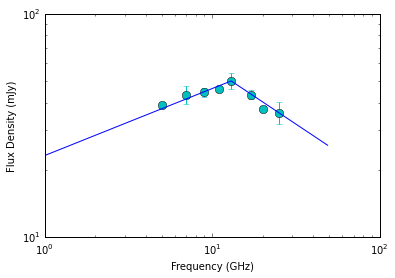

In [34]:
fr=np.arange(1,50,1)
plt.figure()
plt.errorbar(X, Y, yerr=E, fmt='co', ms=8)
#plt.plot(fr,power(fr,50.,13.,0.3))
plt.plot(fr,brok_power(fr,50.,13.,0.3,-0.5))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')

In [36]:
#single
guess=[50.,13.,0.3]
fixp=[False,True,False]
ndim= 3
types='single'
#double
guess=[50.,13.,0.3,-0.5]
fixp=[False,False,False,False]
ndim= 4
types='broken'


print 'number of dimensions is ',ndim
nwalkers = ndim*10
p0 = np.zeros((nwalkers,ndim))
for i in np.arange(ndim):
    if fixp[i]==True:
        p0[:,i]=guess[i]
    elif fixp[i]==False:
        p0[:,i]=(((np.random.randn(nwalkers))*0.01)+guess[i])
sampler = emcee.EnsembleSampler(nwalkers, ndim,lp,args=[X,Y,E,guess,fixp,types])

number of dimensions is  4


In [37]:
lp(guess,X,Y,E,guess,fixp,types)

-27.065126132433409

In [38]:
nBurn=50
with ProgressBar(nBurn,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(p0,iterations=nBurn)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [39]:
sampler.reset()
nSamp=500
with ProgressBar(nSamp,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(pos,iterations=nSamp)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [48]:
if types=='single':
    amp=confidenceInterval(sampler.flatchain[:,0],1)
    alpha=confidenceInterval(sampler.flatchain[:,2],1)
    nu_ref=confidenceInterval(sampler.flatchain[:,1],1)
    print 'Amplitude: ',amp[0],'+',amp[2],'-', amp[1]
    print 'Spectral index: ',alpha[0],'+',alpha[2],'-', alpha[1]
    print 'nu_ref: ',nu_ref[0]
elif types=='broken':
    ampb=confidenceInterval(sampler.flatchain[:,0],1)
    nub=confidenceInterval(sampler.flatchain[:,1],1)
    a1=confidenceInterval(sampler.flatchain[:,2],1)
    a2=confidenceInterval(sampler.flatchain[:,3],1)
    print 'Amplitude at break: ',ampb[0],'+',ampb[2],'-', ampb[1]
    print 'Break frequency: ',nub[0],'+',nub[2],'-', nub[1]
    print 'Spectral index 1: ',a1[0],'+',a1[2],'-', a1[1]
    print 'Spectral index 2: ',a2[0],'+',a2[2],'-', a2[1]

Amplitude at break:  48.1752719812 + 1.43505633896 - 1.42239801673
Break frequency:  13.8602355852 + 1.02784178031 - 1.43044847553
Spectral index 1:  0.211284156171 + 0.0490762088918 - 0.045924557652
Spectral index 2:  -0.644245090894 + 0.208753086997 - 0.199425055483


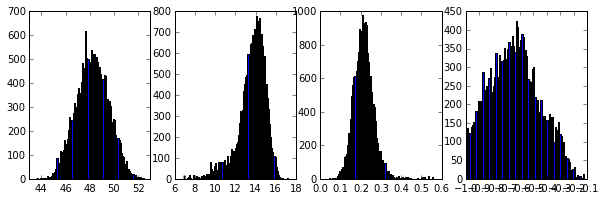

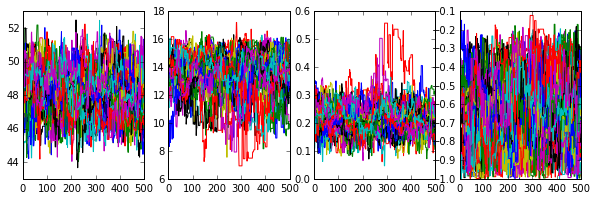

In [42]:
figa = plt.figure(figsize=(10,3))
for i in range(0,ndim):
    plt.subplot(1,4,i+1)
    patches = plt.hist(sampler.flatchain[:,i],bins=100)
figa.subplots_adjust(hspace=.5)


figb = plt.figure(figsize=(10,3))
for i in range(0,ndim):
    plt.subplot(1,4,i+1)
    plt.plot(sampler.chain[:,:,i].T)
figb.subplots_adjust(hspace=.5)

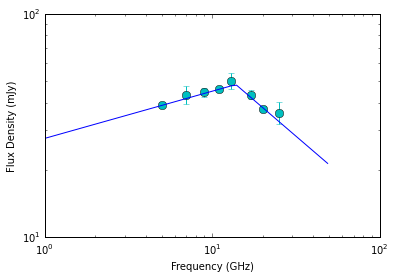

In [43]:
plt.figure()
plt.errorbar(X, Y, yerr=E, fmt='co', ms=8)
if types=='single':
    plt.plot(fr,power(fr,amp[0],nu_ref[0],alpha[0]))
elif types=='broken':
    plt.plot(fr,brok_power(fr,ampb[0],nub[0],a1[0],a2[0]))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux Density (mJy)')
plt.yscale('log')
plt.xscale('log')